In [36]:
import pickle, os
import ast
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from scipy.spatial.distance import pdist, squareform
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

In [37]:
### as with all of these, the first time you run, set save to True and processed to False, then switch after
processed = False
save = True
pickle_import = pickle.load(open('./processed_sorted_indiv_building_data_new.pkl', 'rb'))
sorted_b_7,sorted_b_61,sorted_b_84 = pickle_import['sorted_b_7'],pickle_import['sorted_b_61'],pickle_import['sorted_b_84']
combined_data = pd.concat([sorted_b_7,sorted_b_61,sorted_b_84], axis=0)
if processed:
    peaks_data_og_with_metab = pd.read_csv('./models_stability_cleaned_metals_mz_rt_metfrag_votes_named_new.csv', index_col=0)
else:
    peaks_data_og_with_metab = pd.read_csv('./stability_added_partly_cleaned_metals_combined_mz_rt_metfrag_votes_isotopes_mzrt_noname_new.csv', index_col=0)

In [38]:
warnings.filterwarnings("ignore")
def get_classifier(classifier):
    if classifier == 'LR':
        return LogisticRegressionCV(cv=3, penalty='l1', solver='saga', n_jobs=-1)
    elif classifier == 'RF':
        return RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
        return
    
def train_models_plot_roc(data, labels, n_classes, plot=True):
    base_fpr = np.linspace(0,1,100)
    for classifier in ['LR', 'RF']:
        scores = []
        feat_import = []
        fpr = {z:[] for z in range(n_classes)}
        tpr = {z:[] for z in range(n_classes)}
        roc_auc = {z:[] for z in range(n_classes)}
        for i in range(50):
            data_s, labels_s = shuffle(data, labels)
            x_train, x_test, y_train, y_test = train_test_split(data_s, labels_s, test_size=0.25)
            ss = StandardScaler()
            x_train = ss.fit_transform(x_train)
            x_test = ss.transform(x_test)
            clf = get_classifier(classifier)
            clf.fit(x_train, y_train)
            if classifier == 'LR':
                feat_import.append(pd.DataFrame(clf.coef_).T)
            else:
                feat_import.append(pd.DataFrame(clf.feature_importances_))
            scores.append(clf.score(x_test, y_test))
            y_pred = clf.predict_proba(x_test)
            if plot:
                for j in range(n_classes):
                    if n_classes > 2:
                        y_j = [1 if ele == j else 0 for ele in y_test]
                    else:
                        y_j = y_test
                    fpr_j, tpr_j, _ = roc_curve(y_j, y_pred[:, j])
                    roc_auc_j = auc(fpr_j, tpr_j)
                    roc_auc[j].append(roc_auc_j) 
                    tpr_j = interp(base_fpr, fpr_j, tpr_j)
                    tpr_j[0] = 0.0 #just to make it start at 0
                    tpr[j].append(tpr_j)
                    fpr[j].append(fpr_j)
        scores = np.asarray(scores)    
        print('the 50x repeated average accuracy for model {} is: '.format(classifier), scores.mean(), '+/-', scores.std())
        
        if plot:
            plt.figure(figsize=(5,4.5))   
            colors = ['k','b','g']
            colors = colors[:n_classes]
            for i, c in zip(range(n_classes), colors):
                tprs = np.array(tpr[i])
                print(tprs)
                mean_tpr = tprs.mean(axis=0)
                std = tprs.std(axis=0)
                tprs_upper = np.minimum(mean_tpr + std, 1)
                tprs_lower = mean_tpr - std
                aucs = np.asarray(roc_auc[i])
                plt.plot(base_fpr, mean_tpr, c,linewidth=2.0, label='class %s mean' %(str(i)))
                plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
            plt.plot([0, 1], [0, 1],'r--', linewidth=1.0, label='Random') 
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.tick_params(axis='both', which='major', labelsize=10)
            plt.xlabel('False Positive Rate', fontsize=11)
            plt.ylabel('True Positive Rate', fontsize=11)
            plt.title('{} ROC analysis - Overall accuracy {:.3f}+/-{:.3f}'.format(classifier,scores.mean(),scores.std()), fontsize=12)
            leg = plt.legend(loc=(0.5,0), fontsize=10, framealpha=0.0)
            for line in leg.get_lines():
                line.set_linewidth(1)
            ax = plt.gca()
            ax.get_xaxis().set_tick_params(direction='out', width=1)
            ax.get_yaxis().set_tick_params(direction='out', width=1)
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            plt.tight_layout()
            plt.show() 

In [9]:
#### wednesday-to-saturday classifier:
def get_indicies(df, w_s=False):
    inds = list(df.index)
    if w_s:
        inds = [ele for ele in inds if 'Sa' in ele or 'W' in ele]
    return df.loc[inds]

#### for individual buildings:
print('individual buildings week v. weekend')
for building in [sorted_b_7, sorted_b_61, sorted_b_84]:
    w_sa_building = get_indicies(building, w_s=True)
    building_ind = list(w_sa_building.index)
    day_labels = [1 if 'Sa' in ele else 0 for ele in building_ind]
    train_models_plot_roc(w_sa_building, day_labels, 2, plot=False)
#### for all buildings together in one model
print('Combining all buildings together, week v. weekend')
data_ = pd.concat([sorted_b_7, sorted_b_61, sorted_b_84], axis=0)
w_sa_building = get_indicies(data_)
building_ind = list(w_sa_building.index)
day_labels = [0 if 'W' in ele else 1 for ele in building_ind]
train_models_plot_roc(w_sa_building, day_labels, 2, plot=False)


#### for individual buildings:
print('individual buildings wed v. sat')
for building in [sorted_b_7, sorted_b_61, sorted_b_84]:
    w_sa_building = get_indicies(building, w_s=True)
    building_ind = list(w_sa_building.index)
    day_labels = [1 if 'Sa' in ele else 0 for ele in building_ind]
    train_models_plot_roc(w_sa_building, day_labels, 2, plot=False)
#### for all buildings together in one model
print('Combining all buildings together, wed v. sat')
data_ = pd.concat([sorted_b_7, sorted_b_61, sorted_b_84], axis=0)
w_sa_building = get_indicies(data_, w_s=True)
building_ind = list(w_sa_building.index)
day_labels = [0 if 'W' in ele else 1 for ele in building_ind]
train_models_plot_roc(w_sa_building, day_labels, 2, plot=False)

individual buildings week v. weekend
the 50x repeated average accuracy for model LR is:  0.76 +/- 0.18
the 50x repeated average accuracy for model RF is:  0.765 +/- 0.16889345754054538
the 50x repeated average accuracy for model LR is:  0.48400000000000004 +/- 0.17928747864811975
the 50x repeated average accuracy for model RF is:  0.4800000000000001 +/- 0.2039607805437114
the 50x repeated average accuracy for model LR is:  0.41 +/- 0.23323807579381203
the 50x repeated average accuracy for model RF is:  0.425 +/- 0.2410912690248239
Combining all buildings together, week v. weekend
the 50x repeated average accuracy for model LR is:  0.6344444444444445 +/- 0.11171502546023183
the 50x repeated average accuracy for model RF is:  0.5944444444444444 +/- 0.09638528651609707
individual buildings wed v. sat
the 50x repeated average accuracy for model LR is:  0.725 +/- 0.2410912690248239
the 50x repeated average accuracy for model RF is:  0.75 +/- 0.21213203435596426
the 50x repeated average accu

OK Now we move on to a building classifier

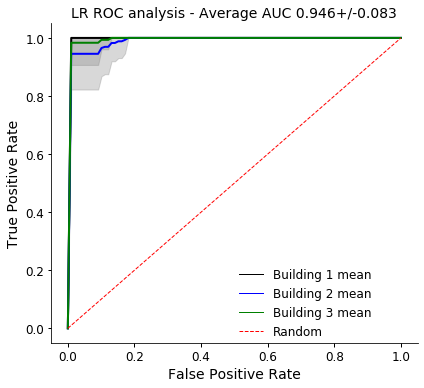

the 50x repeated average accuracy is:  0.9457142857142857 +/- 0.08275856204548708


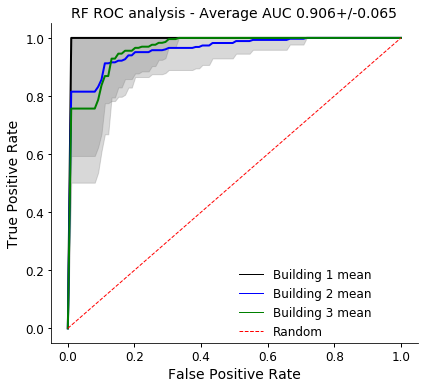

the 50x repeated average accuracy is:  0.9057142857142857 +/- 0.0645865974597561


In [39]:
#### building classifier:

b_7_labels = [0 for i in range(sorted_b_7.shape[0])]
b_61_labels = [1 for i in range(sorted_b_61.shape[0])]
b_84_labels = [2 for i in range(sorted_b_84.shape[0])]
labels = np.asarray(b_7_labels + b_61_labels + b_84_labels)
data = pd.concat([sorted_b_7, sorted_b_61, sorted_b_84], axis=0)
n_classes = 3
base_fpr = np.linspace(0,1,100)

for classifier in ['LR', 'RF']:
    scores = []
    feat_import = []
    fpr = {z:[] for z in range(n_classes)}
    tpr = {z:[] for z in range(n_classes)}
    roc_auc = {z:[] for z in range(n_classes)}
    for i in range(50):
        data_s, labels_s = shuffle(data, labels)
        x_train, x_test, y_train, y_test = train_test_split(data_s, labels_s, test_size=0.20)
        ss = StandardScaler()
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)
        clf = get_classifier(classifier)
        clf.fit(x_train, y_train)
        if classifier == 'LR':
            feat_import.append(pd.DataFrame(clf.coef_).T)
        else:
            feat_import.append(pd.DataFrame(clf.feature_importances_))
        scores.append(clf.score(x_test, y_test))
        y_pred = clf.predict_proba(x_test)
        for j in range(n_classes):
            y_j = [1 if ele == j else 0 for ele in y_test]
            fpr_j, tpr_j, _ = roc_curve(y_j, y_pred[:, j])
            roc_auc_j = auc(fpr_j, tpr_j)
            roc_auc[j].append(roc_auc_j) 
            tpr_j = interp(base_fpr, fpr_j, tpr_j)
            tpr_j[0] = 0.0 #just to make it start at 0
            tpr[j].append(tpr_j)
            fpr[j].append(fpr_j)

    scores = np.asarray(scores)        
    plt.figure(figsize=(6,5.5))   
    for i, c in zip(range(n_classes), ['k','b','g']):
        tprs = np.array(tpr[i])
        mean_tpr = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tpr + std, 1)
        tprs_lower = mean_tpr - std
        aucs = np.asarray(roc_auc[i])
        plt.plot(base_fpr, mean_tpr, c,linewidth=2.0, label='Building %s mean' %(str(i+1)))
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--', linewidth=1.0, label='Random') 
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title('{} ROC analysis - Average AUC {:.3f}+/-{:.3f}'.format(classifier,scores.mean(),scores.std()),  fontname='sans-serif', fontsize=14)
    leg = plt.legend(loc=(0.5,0), fontsize=12, framealpha=0.0)
    for line in leg.get_lines():
        line.set_linewidth(1)
    ax = plt.gca()
    ax.get_xaxis().set_tick_params(direction='out', width=1)
    ax.get_yaxis().set_tick_params(direction='out', width=1)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('False Positive Rate', fontname='sans-serif', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontname='sans-serif', fontsize=14)
    for label in (ax.get_yticklabels()):
        label.set_fontsize(12)
        label.set_fontname('sans-serif')
    for label in (ax.get_xticklabels()):
        label.set_fontsize(12)
        label.set_fontname('sans-serif')
    plt.tight_layout()
    plt.savefig('Fig7_{}_new.svg'.format(classifier), format='svg', dpi=1000, bbox_inches='tight')
    plt.show() 
        
    feat_import = pd.concat(feat_import, axis=1)
    if classifier == 'LR':
        #### getting number of times that the features are non-zero
        non_zero = []
        for i in range(3):
            non_zero.append(feat_import[i].astype(bool).sum(axis=1))
        non_zero = pd.concat(non_zero, axis=1)
        non_zero.columns = ['feature_0_sum', 'feature_1_sum', 'feature_2_sum']
        LR_non_zero = pd.concat([non_zero,feat_import], axis=1)
    else:
        ###getting avg for the RF features...
        RF_avg = feat_import.mean(axis=1)
        RF_avg = RF_avg.rename('average')
        RF_std = feat_import.std(axis=1)
        RF_std = RF_std.rename('std')
        RF_feat_with_avg_std = pd.concat([RF_avg, RF_std, feat_import], axis=1)
    print('the 50x repeated average accuracy is: ', scores.mean(), '+/-', scores.std())
    
if save:
    LR_non_zero.to_csv('./LR_50x_feature_importance_new.csv')
    RF_feat_with_avg_std.to_csv('./RF_50x_feature_importance_new.csv')    

In [11]:
if not processed:
    df_LR = pd.read_csv('./LR_50x_feature_importance_new.csv')
    df_RF = pd.read_csv('./RF_50x_feature_importance_new.csv')
    peaks_data_og_with_metab['RF_feat_avg'] = df_RF['average'].values
    peaks_data_og_with_metab['RF_feat_std'] = df_RF['std'].values
    peaks_data_og_with_metab['LR_model_1_sum'] = df_LR['feature_0_sum'].values
    peaks_data_og_with_metab['LR_model_2_sum'] = df_LR['feature_1_sum'].values
    peaks_data_og_with_metab['LR_model_3_sum'] = df_LR['feature_2_sum'].values

In [19]:
##### this is for getting the indicies of the metabs of interest
######## NOTE the indicies here are just 0-1439 so they dont actually match to the correct indicies... ######
#### if the metab feature is non zero in >40 of the models, find info with it...
RF_feat_with_avg_std = RF_feat_with_avg_std.sort_values('average',ascending=False)
high_import_feats = RF_feat_with_avg_std[RF_feat_with_avg_std['average'] > 0.005].index
rf_feat = set(peaks_data_og_with_metab.iloc[high_import_feats,:]['metfrag_matched_best_guess'])

### LR part:
### first three columns in the LR data are the counts of a feature being non-zero
LR_non_zero.iloc[:,0:3]
LR_important_metabs = []
all_col = []
for i in range(3):
    col = LR_non_zero[LR_non_zero.iloc[:,i]>40].index
    all_col.append(col) ####  actually the indicies
    LR_important_metabs.append(set(peaks_data_og_with_metab.iloc[col,:]['metfrag_matched_best_guess'])) ## the metab data
m_1,m_2,m_3 = LR_important_metabs 
## to get the indicies of the combined important metabolites:
c_1,c_2,c_3 = all_col
combined_col = c_1 | c_2 | c_3

#### comment out everything below the next lines and run to get names:
# new = m_1 | m_2 | m_3
# new & rf_feat
#### STOP....paste the output **except the start and end { and } into labels = []
#####
labels = ['216.03629Da/34.82349',
 '237.93104Da/209.2619s',
 '257.19547Da/491.08835s',
 '320.19064Da/475.77286',
 '331.22431Da/330.17615s',
 '359.25568Da/381.54309',
 '489.20314Da/226.67616',
 '[("4\'-n-desmethylolanzapine", 1.0)]',
 "[('(2-hydroxyethoxy)sulfonic acid**', '0.482', 'M-H_hmdb', 'C2H6O5S1')]",
 "[('1-(3-chlorophenyl)-4-hexylpiperazine**', '0.128', 'M-H_chebi', 'C16H25Cl1N2')]",
 "[('2-[[2-[2-(2,3-dihydroindol-1-yl)-2-oxoethyl]-1-oxo-5-isoquinolinyl]oxy]acetic acid ethyl ester**', '3.826', 'M-H_chebi', 'C23H22N2O5')]",
 "[('2-c-methyl-d-erythritol 4-phosphate', 1.0)]",
 "[('2-hydroxyethanesulfonate', 1.0)]",
 "[('5(s)-hydroperoxyeicosatetraenoic acid', 1.0), ('15(s)-hpete', 1.0), ('lmfa03060044', 1.0), ('lmfa03060045', 1.0), ('12(r)-hpete', 1.0), ('11(r)-hpete', 1.0), ('9s-hpete', 1.0), ('8(s)-hpete', 1.0), ('12(r)-hpete', 1.0), ('11(r)-hpete', 1.0), ('8(s)-hpete', 1.0), ('5-hpete', 1.0), ('15-hpete', 1.0), ('5-hpete', 1.0), ('15(s)-hpete', 1.0), ('9(s)-hpete', 1.0)]",
 "[('5-nitrosalicylate', 1.0)]",
 "[('6-keto-decanoylcarnitine', 1.0)]",
 "[('7s,8s-dihode', 1.0), ('5s,8r-dihode', 1.0), ('(7s,8s)-dihode', 1.0), ('15,16-dihode', 1.0), ('(±)-(e)-13-hydroxy-10-oxo-11-octadecenoic acid', 1.0)]",
 "[('Zanthobisquinolone**', '4.035', 'M-H_hmdb', 'C21H18N2O4')]",
 "[('diisopropyl sulfate', 1.0)]",
 "[('ferulic acid 4-sulfate', 1.0), ('isoferulic acid 3-sulfate', 1.0)]",
 "[('girgensonine', 1.0)]",
 "[('l-2,3-dihydrodipicolinate', 1.0), ('2-furoylglycine', 1.0)]",
 "[('n-acetyl-5-aminosalicylic acid', 1.0), ('6-hydroxy-3-succinoylpyridine', 1.0)]",
 "[('n-decanoylglycine', 1.0)]",
 "[('n-lauroylglycine', 1.0)]",
 "[('pantothenol', 1.0)]",
 "[('ropinirole', 1.0)]"]
new_combined_col = []
for ele in combined_col:
    if peaks_data_og_with_metab.iloc[ele,:]['metfrag_matched_best_guess'] in labels:
        new_combined_col.append(ele)
true_indicies = list(peaks_data_og_with_metab.iloc[new_combined_col,:].index)
print(true_indicies)
print(peaks_data_og_with_metab.iloc[new_combined_col,:])

[69, 186, 363, 462, 542, 644, 720, 726, 739, 811, 866, 953, 976, 983, 1061, 1096, 1194, 1213, 1347, 1376, 1396, 1409, 1436, 1478, 1481, 1608, 1777]
                    mz      mzmin      mzmax         rt      rtmin      rtmax  \
true_labels                                                                     
69           124.99134  124.99100  124.99153   34.47959   32.18073   54.06141   
186          140.98625  140.98601  140.98647   36.65969   25.72635   38.51917   
363          168.03020  168.03007  168.03028  183.51859  175.84329  191.17975   
462          182.00946  182.00940  182.00955  294.75961  294.17490  295.92923   
542          194.04581  194.04508  194.04614  248.99940  246.68362  250.86308   
644          204.12421  204.12309  204.12436  189.30145  186.84338  216.59744   
720          215.03296  215.03257  215.03325   34.81924   32.57743   36.71096   
726          216.03629  216.03601  216.03656   34.82349   32.18073   35.82255   
739          217.03004  217.02965  217.030

### NOW TO SAVE THE MODELS AND NEW PD DF WITH PEAKS/NAMES/STABILITES/FEATURE IMPORTANCE

In [13]:
if save:
    peaks_data_og_with_metab.to_csv('./models_stability_cleaned_metals_mz_rt_metfrag_votes_named_new.csv')

In [14]:
best_comps = peaks_data_og_with_metab.iloc[new_combined_col,:][['mz','rt','metfrag_matched_best_guess','unstable_type_b7','unstable_type_b61','unstable_type_b84', 'RF_feat_avg', 'RF_feat_std','LR_model_1_sum','LR_model_2_sum','LR_model_3_sum' ]]
best_comps.replace({'selective_attender':'unstable-3', 'bottom_feeder':'unstable-1', 'high_flier':'unstable-2'})
best_comps.to_csv('./best_model_compounds_new.csv')

In [1]:
def process_dataset(df):
    ind = list(df.index)
    ind = {ele:ele.split('B')[0] for ele in ind}
    df = df.rename(index=ind)
    ind_df = set(df.index)
    return df, ind_df

sorted_b_7, ind_7 = process_dataset(sorted_b_7)
sorted_b_61, ind_61 = process_dataset(sorted_b_61)
sorted_b_84, ind_84 = process_dataset(sorted_b_84)
common = ['T_O3','W_O4','R_O5','F_O6','W_O11','W_O18','F_O20','Sa_O21','M_O23',
          'Sa_N4','W_N22','Sa_D2','W_D6','Sa_D9','W_D13','Sa_D16']
sorted_b_7 = sorted_b_7.loc[common]
sorted_b_61 = sorted_b_61.loc[common]
sorted_b_84 = sorted_b_84.loc[common]

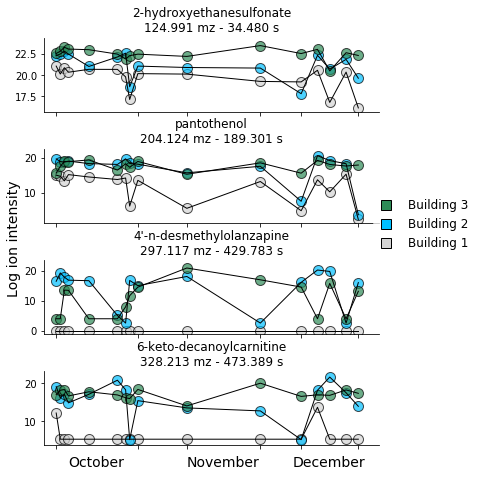

In [22]:
##### figure 7 b...
def plot_single_ts(ax, index, title, mz, rt,i):
    title = ast.literal_eval(title)
    title = [ele[0] for ele in title]
    if len(title) > 3:
        title = 'Multiple matches see SI'+ '\n' +'{:.3f} Da - {:.3f} s'.format(mz, rt)
    else:
        title = '/'.join(title) + '\n' +'{:.3f} mz - {:.3f} s'.format(mz, rt)
    ax.set_title(title,fontname='sans-serif', fontsize=12)
    colors = ['lightgray', 'deepskyblue', 'seagreen']
    if i == 2:
        legend_data = [['Building 3', colors[2], 'k', 's'],
                       ['Building 2', colors[1], 'k', 's'],
                       ['Building 1', colors[0], 'k', 's']]
        patches_bar = []
        for ele in legend_data:
            patches_bar.append(Line2D([0],[0], color='w', marker=ele[3],markerfacecolor=ele[1], markeredgecolor=ele[2], label=ele[0], markersize=10)) 
        font = font_manager.FontProperties(family='sans-serif', style='normal', size=12)
        lgd = ax.legend(handles=patches_bar, bbox_to_anchor=(1.3, 1.97), frameon=False, prop=font)
    for b_ts, c in zip([sorted_b_7,sorted_b_61,sorted_b_84], colors):
        ax.scatter([1,2,3,4,9,16,18,19,21,33,51,61,65,68,72,75], b_ts[index], c=c, s=100, alpha=0.7, edgecolor='k')
        ax.plot([1,2,3,4,9,16,18,19,21,33,51,61,65,68,72,75], b_ts[index], 'k', linewidth=1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xticks([1,21,33,51,61,75])
        ax.set_xticklabels([])
        ax.set_xlim([-2,80])
        for label in (ax.get_yticklabels()):
            label.set_fontsize(10)
            label.set_fontname('sans-serif')
        for label in (ax.get_xticklabels()):
            label.set_fontsize(10)
            label.set_fontname('sans-serif')
        
def plot_time_series_different_types(indicies):
    fig = plt.figure(figsize=(6,7.5))
    gs = GridSpec(4,1, figure=fig,hspace=0.5)
    seen = []
    j=0
    titles = list(peaks_data_og_with_metab.loc[indicies]['metfrag_matched_best_guess'])
    mzs = list(peaks_data_og_with_metab.loc[indicies]['mz'])
    rts = list(peaks_data_og_with_metab.loc[indicies]['rt'])
    for i, ind, title,mz,rt in zip([0,1,2,3],indicies, titles, mzs, rts):
        ax = plt.subplot(gs[i])
        j+=1
        if i==3:
            ax.text(4,-2,'October',fontname='sans-serif', fontsize=14)
            ax.text(33,-2,'November', fontname='sans-serif', fontsize=14)
            ax.text(59,-2,'December', fontname='sans-serif', fontsize=14)
        if i == 2:
            ax.text(-11,12.5,'Log ion intensity',fontname='sans-serif', fontsize=14, rotation=90)
        plot_single_ts(ax,ind, title, mz, rt,i)
    plt.savefig('Fig7_b_new.svg', format='svg', dpi=1000, bbox_inches='tight')

plot_time_series_different_types([69,644,1213,1376]) 

In [23]:
#### get the interesting metabolites and save as csv: (contains duplicates)
fig_1_metabs = [312,460,644,750,277,783,1368,823,962,1194,1636,996,1213,69,355,454,553,340,441,1012,65,1125,1126,1872,702] # never changed
fig_2c_metabs = [69, 363, 460, 720, 967, 1021, 1291, 1387, 1484, 1608, 1652, 1720] # updated
fig_2d_metabs = [895,1365,702,1010,1060,1724] # updated
fig_6_metabs = [535, 767, 1067, 1126, 1240, 1241, 1359, 1360, 1368, 1395, 1473, 1541, 1545, 1751, 1770, 1831, 1836, 2186, 340, 441, 526, 580, 582, 583, 823, 996, 1368, 954, 981, 1320, 1364, 1521, 1591, 1600, 1763, 1880, 2157] # up to date 
fig_7_metab = [69,644,1213,1376] # updated
fig_7_SI_metabs = [69, 186, 363, 462, 542, 644, 720, 726, 739, 811, 866, 953, 976, 983, 1061, 1096, 1194, 1213, 1347, 1376, 1396, 1409, 1436, 1478, 1481, 1608, 1777] # updated
all_figs = fig_1_metabs + fig_2c_metabs + fig_2d_metabs + fig_6_metabs + fig_7_metab + fig_7_SI_metabs
for f, metabs in zip(['1','2c','2d','6','7','7_SI'],[fig_1_metabs, fig_2c_metabs, fig_2d_metabs, fig_6_metabs, fig_7_metab, fig_7_SI_metabs]):
    small_df = peaks_data_og_with_metab.loc[metabs,['mz','rt','metfrag_matched_best_guess','vote_0','vote_1','vote_2','vote_3']]
    if f == '7_SI':
        small_df = peaks_data_og_with_metab.loc[metabs]
    small_df.to_csv(path_or_buf='SI_tables_{}_new.csv'.format(f))

In [24]:
### looking at chemical classes for the important features for the classifiers:


In [27]:
## databases for looking up metab class
db_path = '/home/ubuntu/data/mz_to_metab_mapping/'
dbs_name = {'chebi':'chebi_metabolites.pkl','hmdb':'hmdb_metabolites.pkl',
       'lipidmap':'lipidmap_metabolites.pkl','metacyc':'metacyc_metabolites.pkl'}
dbs = {'chebi':None,'hmdb':None,'lipidmap':None,'metacyc':None, 
       'lipid_msms':None, 'hmdb_msms':None, 'kegg_msms':None}
for db in dbs_name:
    db_ = pickle.load(open(os.path.join(db_path,dbs_name[db]), 'rb'))
    db_lc = {k.lower():v for k,v in db_.items() if type(k)==str}
    dbs[db] = db_lc

inchi_lookups = {'hmdb':None, 'lipidmap':None}
for ele in ['hmdb', 'lipidmap']:
    db = dbs[ele]
    new_db = {}
    for ent in db:
        new_db[db[ent]['inchikey']] = db[ent]
    inchi_lookups[ele] = new_db
    
extra_db_path = '/home/ubuntu/data/mz_to_metab_mapping/msms_pipeline_analysis/essentials/'
csv_dbs = ['lipidmaps.csv','kegg_2017-07-23.csv']
for db_name, csv in zip(['lipid_msms','kegg_msms'], csv_dbs): 
    msms_db = open(os.path.join(extra_db_path, csv), 'r')
    new_db = {}
    for line in msms_db:
        line = line.strip().split('","')
        if db_name == 'lipid_msms':
            new_db[line[0][1:].lower()] = {'mass':line[1],'formula':line[3],'class':line[5], 'sub_class':line[6],
                                           'inchi':line[8][6:], 'inchikey':'-'.join([line[9],line[10],line[12]])}
    dbs[db_name] = new_db



In [28]:
def accession_to_name(dbs):
    acc_to_name = {}
    for ele in dbs['hmdb']:
        for acc in dbs['hmdb'][ele]['hmdb_accession']:
            acc_to_name[acc] = ele
    return acc_to_name

def inchikey_to_name(dbs):
    inchi_to_name = {}
    for ele in dbs['hmdb']:
        inchikey = dbs['hmdb'][ele]['inchikey']
        inchi_to_name[inchikey] = ele
    return inchi_to_name

def inchi_to_name(dbs):
    inchi_to_name = {}
    for ele in dbs['hmdb']:
        inchi = dbs['hmdb'][ele]['inchi']
        inchi_to_name[inchi] = ele
    return inchi_to_name

### get the accessions matching to HMDB names:
acc_to_name_hmdb = accession_to_name(dbs)
### get the inchikey to name for HMDB:
inchikey_to_name_hmdb = inchikey_to_name(dbs)
### get the inchi to name for HMDB:
inchi_to_name_hmdb = inchi_to_name(dbs)

In [29]:
## class / sub_class / type analysis for stable and nonstable
## idea: take the labels, look up the compound in df, take the name and look into the DBs
def get_names(inds, name_df):
    names = list(name_df.loc[inds,'metfrag_matched_best_guess'].values)
    names_w_inds = [[n,i] for n,i in zip(names,inds)]
    total = len(names_w_inds)
    names_w_inds = [ele for ele in names_w_inds if 'Da/' not in ele[0]]
    num_remaining = len(names)
    removed = total - num_remaining
    names = [ast.literal_eval(ele[0]) for ele in names_w_inds]
    inds = [ele[1] for ele in names_w_inds]
    new_names = []
    new_inds = []
    for group,ind in zip(names,inds):
        new_group = []
        for chem in group:
            if len(chem) == 4 and 'C13' in chem[2]:
                continue
            if '**' in chem[0]:
                new_group.append(chem[0][:-2].lower())
            else:
                new_group.append(chem[0].lower())
        if len(new_group) == 0:
            num_remaining -= 1
            removed += 1
        else:
            new_names.append(new_group)
            new_inds.append(ind)
    return new_names, new_inds

def db_name_look_up(name, dbs):
    ### lipidmaps category = hmdb class
    ### lipidmaps main class = hmdb subclass
    ### lipidmaps sub class = hmdb direct parent
    db_info = []
    for db in ['hmdb','lipidmap', 'lipid_msms', 'chebi', 'metacyc']:
        db_info_ = []                
        try:
            chem = dbs[db][name]
            if db == 'hmdb':
                cats = ['class', 'sub_class', 'direct_parent']
            else:
                if chem['hmdb'] != None:
                    try:
                        if type(chem['hmdb']) == list:
                            for acc in chem['hmdb']:
                                try:
                                    hmdb_name = acc_to_name_hmdb[acc]
                                    chem = dbs['hmdb'][hmdb_name]
                                    cats = ['class', 'sub_class', 'direct_parent']
                                    break
                                except:
                                    pass
                        else:
                            hmdb_name = acc_to_name_hmdb[chem['hmdb']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                    except:
                        try:
                            hmdb_name = inchikey_to_name_hmdb[chem['inchikey']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                        except:
                            try:
                                hmdb_name = inchi_to_name_hmdb[chem['inchi']]
                                chem = dbs['hmdb'][hmdb_name]
                                cats = ['class', 'sub_class', 'direct_parent']
                            except:
                                cats = ['category','class','sub_class','super_class','inchikey','inchi']
                else:
                    try:
                        hmdb_name = inchikey_to_name_hmdb[chem['inchikey']]
                        chem = dbs['hmdb'][hmdb_name]
                        cats = ['class', 'sub_class', 'direct_parent']
                    except:
                        try:
                            hmdb_name = inchi_to_name_hmdb[chem['inchi']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                        except:
                            cats = ['category','class','sub_class','super_class','inchikey','inchi']
            for ele in cats:
                try:
                    if type(chem[ele]) == list:
                        db_info_.append(chem[ele][0])
                    else:
                        db_info_.append(chem[ele])
                except:
                    db_info_.append(None)
            if len(db_info_) > 3:
                db_info_ = []
                try:
                    db_info_.append(chem['category'])
                    db_info_.append(chem['class'])
                    db_info_.append(chem['sub_class'])
                except:
                    db_info_.append(None)
            if set(db_info_) == set([None]):
                continue
            if db_info_ not in db_info:
                db_info.append(db_info_)
                break
        except:
            pass
    return db_info

def names_lookup(names_list, dbs):
    name_to_groups = {}
    for i, group in enumerate(names_list):
        group_info = []
        for chem in group:
            db_info = db_name_look_up(chem, dbs)
            if len(db_info) == 0:
                continue
            elif db_info[0] in group_info:
                continue
            else:
                group_info += db_info
        name_to_groups[i] = group_info
    return name_to_groups

def make_hist(list_of_names):
    h = {}
    for ele in list_of_names:
        if ele not in h:
            h[ele] = 1
        else:
            h[ele] += 1
    return h

def get_best_name(names, priority='middle'):
    l1 = names[0]
    l2 = names[1]
    l3 = names[2]
    if priority == 'last':
        if l3 == None:
            if l2 == None:
                return l1
            else:
                return l2
        return l3
    elif priority == 'middle':
        if l2 == None:
            return l1
        else:
            return l2
    elif priority == 'first':
        return l1

def chart_metab_classes(class_to_count, title, priority):
    heights = list(class_to_count.values())
    labels = list(class_to_count.keys())
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    y = [i for i in range(len(labels))]
    ax.barh(y, heights,color='c', edgecolor='k', linewidth=0.5)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_ylim([-0.5,len(labels)-0.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Class counts', fontname='sans-serif', fontsize=12)
    ax.set_title(title+' '+priority, fontname='sans-serif', fontsize=14)
        
    if save:
        plt.savefig('metab_types_{}_{}.svg'.format('_'.join(title.split(' ')),'_'.join(priority.split(' '))), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()

def get_max_classes(class_dict, x):
    list_d = sorted([(k,v) for k,v in class_dict.items()],key=lambda x:x[1], reverse=True)
    top_dict = {kv[0]:kv[1] for kv in list_d[:x]}
    return top_dict

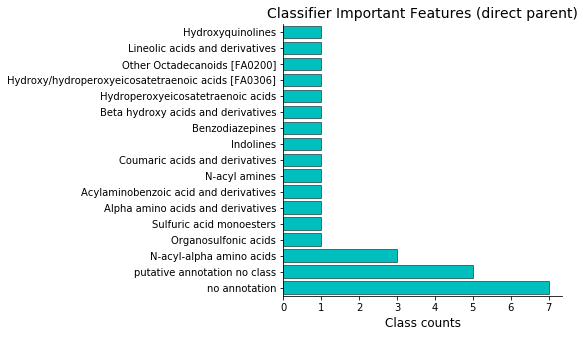

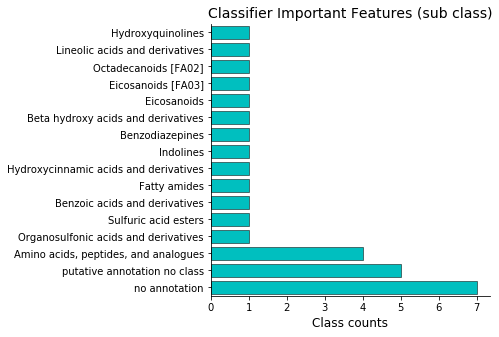

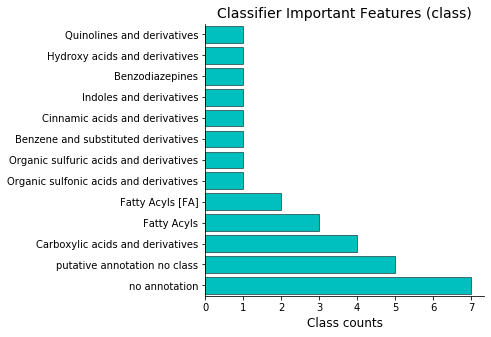

In [30]:
title = 'Classifier Important Features'
all_comp = list(peaks_data_og_with_metab.loc[fig_7_SI_metabs,'metfrag_matched_best_guess'].values)
not_annot = [ele for ele in all_comp if 'Da/' in ele]
names_met_c,s_inds_met_c = get_names(fig_7_SI_metabs, peaks_data_og_with_metab)
named_groups_met_c = names_lookup(names_met_c, dbs)
for pri,pri_class in zip(['last', 'middle', 'first'],['(direct parent)', '(sub class)', '(class)']):
    all_groups = {'no annotation':len(not_annot), 'putative annotation no class':0}
    for k, metab_groups in named_groups_met_c.items():
        if 'Da/' not in all_comp[k]:
            all_put_comps = ast.literal_eval(all_comp[k])
            if (len(all_put_comps) != 0 and len(metab_groups) == 0):
                all_groups['putative annotation no class']+= int(len(all_put_comps)-len(metab_groups))
        for sub_g in metab_groups:
            sub_g_class = get_best_name(sub_g, priority=pri)
            if sub_g_class not in all_groups:
                all_groups[sub_g_class] = 1
            else:
                all_groups[sub_g_class] += 1  
    all_groups = get_max_classes(all_groups,20)
    chart_metab_classes(all_groups, title, pri_class)